In [20]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from loess.Loess import Loess
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm
import seaborn as sns
import loess
import random

In [154]:
wnv_file_path= "/Users/sparshagarwal/Downloads/WMV_data/Arbovirus_risk_modeling_US/WNV_human_cases/WNV_NI_NNI_1999to2015_prevalence_incidence_final_20180530.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/aggregate/filtered_aggregated_precipitation.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/dry_days/dry_days_filtered.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/dry_days/max_consecutive_dry_days.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/gini/gini_index_summer.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/gini/gini_index.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/gini/gini_weekly.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/theil/theil_index_summer.csv"
#data_path="/Users/sparshagarwal/Downloads/urban_county_indices/theil/theil_index.csv"
data_path="/Users/sparshagarwal/Downloads/urban_county_indices/theil/theil_weekly.csv"

In [155]:
#variable="filtered_aggregated_precipitation"
#variable="dry_days_filtered"
#variable="max_consecutive_dry_days"
#variable="gini_index_summer"
#variable="gini_index"
#variable="gini_weekly"
#variable="theil_index_summer"
#variable="theil_index"
variable="theil_weekly"

In [156]:
years=range(1999, 2016)

In [157]:
# Defining socio-economic zones/regions
socio_regions={"WA":1, "OR":1, "CA":1, "MT":2, "ID":2, "WY":2, "NV":2, "UT":2, "CO":2, "AZ":2, "NM":2,"ND":3, "SD":3, "MN":3, "NE":3, "IA":3,"KS":3, "MO":3, "OK":4 , "TX":4, "AR":4, "LA":4, "WI":5, "MI":5, "IL":5, "IN":5, "OH":5, "KY":6, "TN":6, "AL":6, "MS":6, "WV":7, "VA":7, "NC":7, "SC":7, "DC":7, "MD":7, "DE":7, "GA":7, "FL":7, "PA":8, "NJ":8, "NY":8, "MA":9, "CT":9, "NH":9, "VT":9, "ME":9, "RI":9}
socio_key={1:"Pacific", 2:"Mountain", 3:"West North Central", 4: "West South Central", 5: "East North Central", 6: "East South Central", 7: "South Atlantic", 8: "Middle Atlantic", 9: "New England"}

In [158]:
# Defining climatic zones/regions
weather_regions={"WA":1, "OR":1, "ID":1, "NV":2, "CA":2, "MT":3, "WY":3,"ND":3, "SD":3, "NE":3,"UT":4, "CO":4, "AZ":4, "NM":4, "MN":5,"WI":5, "MI":5, "IA":5,"KS":6, "OK":6 , "TX":6, "AR":6, "LA":6, "MS":6, "MO":7 , "IL":7, "IN":7, "OH":7, "KY":7, "TN":7, "WV":7, "AL":8, "VA":8, "NC":8, "SC":8, "GA":8, "FL":8, "DE":9, "DC":9, "MD":9, "PA":9, "NJ":9, "NY":9, "MA":9, "CT":9, "NH":9, "VT":9, "ME":9, "RI":9}
weather_key={1: "Northwest", 2: "West", 3: "West North Central", 4: "Southwest", 5: "East North Central", 6: "South", 7: "Central", 8: "Southeast", 9:"Northeast"}

In [159]:
#Importing WNV yearly data
df= pd.read_csv(wnv_file_path, encoding='latin-1')
df=df[df["Select_County"]==1]
df.rename(columns = {'GEOID10':'GEOID'}, inplace = True)
df=df[df["STNAME"]!="California"]

In [160]:
# Adding a column for incident year
incident_year=[years[-1] for i in range(len(df))]
for j in range(len(df)):
    for i in years:
        if(df.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df["Incident_year"]=incident_year

In [161]:
# Adding data for the variable
df_mod=df.copy()
data=pd.read_csv(data_path)
df_mod=df_mod.join(data.set_index('GEOID'), on='GEOID')

In [162]:
#Adding socioeconomic and weather regions classification column
sc=[]
we=[]
for i in range(len(df_mod)):
    sc.append(socio_regions[df_mod.iloc[i]["STUSPS"]])
    we.append(weather_regions[df_mod.iloc[i]["STUSPS"]])
df_mod["Socio_econ_class"]=sc 
df_mod["Weather_class"]=we

In [163]:
n_sample_years=5    #Number of years to be sampled

In [168]:
#Calculating average of yearly variable value,  for every county and storing all the corresponding attributes 
# in different lists so that a simplified dataframe can be made. 
geo_id=[]
mean_variable=[]
mean_ir=[]
w_cl=[]
s_cl=[]
for i in range(len(df_mod)):
    summer_variable=[]
    summer_ir=[]
    inc_year= df_mod.iloc[i]["Incident_year"]  # 1st year of WNV incidence
    
    sample_years=[]    # For storing n number of sample years
    for rand in range(inc_year+1, years[-1]+1):
        sample_years.append(rand)
    random.seed(10)
    if(len(sample_years)>n_sample_years):
        sample_years=random.sample(sample_years,n_sample_years)
                                     
    for j in sample_years:
        #Calculating and storing the variable value for a certain year.
        summer_variable.append(df_mod.iloc[i][str(j)])    
        summer_ir.append(df_mod.iloc[i]["NI_IR_" + str(j)])
                                   
    if(inc_year!=years[-1]):
        # Calculating mean of varaible across all the years
        mean_variable.append(np.mean(summer_variable))
        mean_ir.append(np.mean(summer_ir))
        geo_id.append(df_mod.iloc[i]["GEOID"])
        w_cl.append(df_mod.iloc[i]["Weather_class"])
        s_cl.append(df_mod.iloc[i]["Socio_econ_class"])
        

In [165]:
#For average across all the years
df_combined=pd.DataFrame()
df_combined["GEOID"]=geo_id
df_combined["IR"]=mean_ir
df_combined[variable]=mean_variable
df_combined["Weather_class"]=w_cl
df_combined["Socio_econ_class"]=s_cl

In [166]:
df_combined=df_combined[df_combined[variable].isnull()==False]
df_combined=df_combined[df_combined["IR"]!=0]   # Removing entries with IR=0

In [167]:
#To export data
df_combined.to_csv(r"/Users/sparshagarwal/Desktop/Weather_sample_years_" + variable + ".csv", index=False)

In [124]:
#df_combined=df_combined[df_combined["Weather_class"]==9]
#df_combined=df_combined[df_combined["Socio_econ_class"]==9]

In [125]:
#Variable for which the trend has to be plotted
var=variable

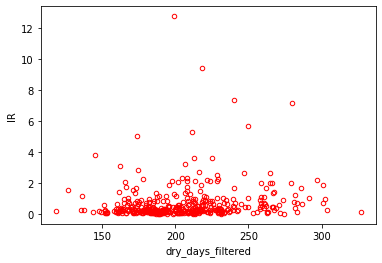

In [22]:
df_combined.plot(kind='scatter',x=var,y='IR',color="None", edgecolors='red')